# Tutorial Q1 - Qubit rotation

This tutorial demonstrates PennyLane's "hello-world" example for qubit-based architectures with the projectq backend. 

The task is to optimize two rotation gates in order to flip a single qubit from state $|0\rangle$ to state $|1\rangle $. 

## Imports

First we need to import pennylane, as well as pennylane's version of numpy. This allows us to automatically compute gradients for functions that manipulate numpy arrays, including quantum functions. We also want to compare two optimizers, basic gradient descent and adagrad.

In [1]:
import pennylane as qm
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer, AdagradOptimizer

Next, create a projecq simulator as a "device" to run the quantum node. We only need a single quantum wire.

In [2]:
dev = qm.device('projectq.simulator', wires=1)

## Quantum node

We define a quantum node called "circuit". The decorator `qm.qfunc(dev1)` that saves us to create a quantum node via `circuit = qm.qnode.QNode(circuit, dev)`. 

In [3]:
@qm.qnode(dev)
def circuit(vars):

    qm.RX(vars[0], [0])
    qm.RY(vars[1], [0])
    
    return qm.expval.PauliZ(0)

This function uses pennylane to run the following quantum circuit:

<img src="figures/rotation_circuit.png">

Starting with a qubit in the ground state, 

$$ |0\rangle = \begin{pmatrix}1 \\ 0 \end{pmatrix}, $$

we first rotate the qubit around the x-axis by 
$$R_x(v_1) = e^{-iv_1 X /2} = 
\begin{pmatrix} \cos \frac{v_1}{2} &  -i \sin \frac{v_1}{2} \\  
                -i \sin \frac{v_1}{2} &  \cos \frac{v_1}{2} 
\end{pmatrix}, $$ 
               
and then around the y-axis by 
$$ R_y(v_2) = e^{-i v_2 Y/2} = 
\begin{pmatrix} \cos \frac{v_2}{2} &  - \sin \frac{v_2}{2} \\  
                \sin \frac{v_2}{2} &  \cos \frac{v_2}{2} 
\end{pmatrix}. $$ 

After these operations the qubit is in the state

$$ | \psi \rangle = R_y(v_1) R_x(v_2) | 0 \rangle $$

Finally, we measure the expectation $ \langle \psi | Z | \psi \rangle $ of the Pauli-Z operator 
$$Z = 
\begin{pmatrix} 1 &  0 \\  
                0 & -1 
\end{pmatrix}. $$ 


Depending on the circuit parameters $v_1$ and $v_2$, the output expectation lies between $1$ (if $| \psi \rangle = | 0  \rangle $) and $-1$ (if $| \psi \rangle = | 1  \rangle $).

## Objective

Next, we define a cost. Here, the cost is directly the expectation of the PauliZ measurement, so that the cost is trivially the output of the circuit.

In [4]:
def objective(vars):
    return circuit(vars)

With this objective, the optimization procedure is supposed to find the weights that rotate the qubit from the ground state 

 <img src="figures/bloch_before.png" width="250"> 
 
 to the excited state
 
 <img src="figures/bloch_after.png" width="250">
 
 The rotation gates give the optimization landscape a trigonometric shape with four global minima and five global maxima. 
 
 *Note: To run the following cell you need the matplotlib library.*

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator


fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 3.1, 0.2)
Y = np.arange(-3.1, 3.1, 0.2)
length = len(X)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(length, length)
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.show()

<Figure size 600x400 with 1 Axes>

## Optimization

The initial values of the x- and y-rotation parameters $v_1, v_2$ are set to near-zero. This corresponds to identity gates, in other words, the circuit leaves the qubit in the ground state.

In [6]:
vars_init = np.array([0.011, 0.012])

The value of the objective at the initial point is close to $1$.

In [7]:
objective(vars_init)

0.9997395193760918

We choose a simple Gradient Descent Optimizer and update the weights for 10 steps. The final parameters correspond to a $Z$ expectation of nearly $-1$, which means that the qubit is flipped.

In [13]:
gd = GradientDescentOptimizer(0.4)


vars = vars_init
vars_gd = [vars]

for it in range(100):
    vars = gd.step(objective, vars)

    if (it+1) % 5 == 0:
        vars_gd.append(vars)
        print('Objective after step {:5d}: {: .7f}'.format(it+1, objective(vars)) )

print('\nOptimized rotation angles: {}'.format(vars))

Objective after step     5:  0.9993246
Objective after step    10:  0.9982497
Objective after step    15:  0.9954699
Objective after step    20:  0.9883159
Objective after step    25:  0.9701280
Objective after step    30:  0.9252888
Objective after step    35:  0.8226045
Objective after step    40:  0.6218840
Objective after step    45:  0.3218872
Objective after step    50: -0.0149679
Objective after step    55: -0.3477552
Objective after step    60: -0.6440175
Objective after step    65: -0.8420738
Objective after step    70: -0.9388981
Objective after step    75: -0.9778339
Objective after step    80: -0.9921600
Objective after step    85: -0.9972525
Objective after step    90: -0.9990403
Objective after step    95: -0.9996652
Objective after step   100: -0.9998832

Optimized rotation angles: [0.00780327 3.12845269]


Starting at a different offset, we train another optimizer called Adagrad, which improves on gradient descent.

*Note: Adagrad, a many other optimizers, has internal hyperparameters that are stored in the optimizer instance (here: `ada`). To reset these hyperparameters, use `ada.reset()`.*

In [16]:
ada = AdagradOptimizer(0.4)

vars = np.array([-0.011, 0.012])
vars_ada = [vars]

for it in range(100):
    vars = ada.step(objective, vars)
    
    if (it+1) % 5 == 0:
        vars_ada.append(vars)
        print('Objective after step {:5d}: {: .7f}'.format(it+1, objective(vars)) )

print('\nOptimized rotation angles: {}'.format(vars))

Objective after step     5:  0.0121498
Objective after step    10: -0.0010478
Objective after step    15: -0.0628869
Objective after step    20: -0.7333553
Objective after step    25: -0.9874048
Objective after step    30: -0.9995463
Objective after step    35: -0.9999838
Objective after step    40: -0.9999994
Objective after step    45: -1.0000000
Objective after step    50: -1.0000000
Objective after step    55: -1.0000000
Objective after step    60: -1.0000000
Objective after step    65: -1.0000000
Objective after step    70: -1.0000000
Objective after step    75: -1.0000000
Objective after step    80: -1.0000000
Objective after step    85: -1.0000000
Objective after step    90: -1.0000000
Objective after step    95: -1.0000000
Objective after step   100: -1.0000000

Optimized rotation angles: [-9.98753488e-13  3.14159265e+00]


Adagrad and gradient descent find the same minimum, and, since neither has information on second order derivatives, both take a detour through a saddle point. However, Adagrad takes considerably fewer steps.

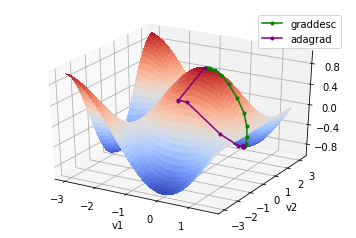

In [17]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3, 1.57, 50)
Y = np.linspace(-3, 3, 50)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [objective(vars)+1e-8 for vars in vars_gd]
path_x = [v[0] for v in vars_gd]
path_y = [v[1] for v in vars_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

path_z = [objective(vars)+1e-8 for vars in vars_ada]
path_x = [v[0] for v in vars_ada]
path_y = [v[1] for v in vars_ada]
ax.plot(path_x, path_y, path_z, c='purple', marker='.', label="adagrad")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.legend()
plt.show()

### Choosing initial variables

The variables are best randomly initialized with near-zero values. To show why constant initializations can go wrong, consider starting at exactly zero. 

In [11]:
vars = np.array([0., 0.])

for it in range(100):
    vars = gd.step(objective, vars)
    if (it+1) % 5 == 0:
        print('Objective after step {:5d}: {: .7f}'.format(it+1, objective(vars)) )

Objective after step     5:  1.0000000
Objective after step    10:  1.0000000
Objective after step    15:  1.0000000
Objective after step    20:  1.0000000
Objective after step    25:  1.0000000
Objective after step    30:  1.0000000
Objective after step    35:  1.0000000
Objective after step    40:  1.0000000
Objective after step    45:  1.0000000
Objective after step    50:  1.0000000
Objective after step    55:  1.0000000
Objective after step    60:  1.0000000
Objective after step    65:  1.0000000
Objective after step    70:  1.0000000
Objective after step    75:  1.0000000
Objective after step    80:  1.0000000
Objective after step    85:  1.0000000
Objective after step    90:  1.0000000
Objective after step    95:  1.0000000
Objective after step   100:  1.0000000


The model is "stuck" in the maximum of the cost function where the gradient vanishes.

Also, symmetric initalizations can go wrong:

In [18]:
vars = np.array([0.1, 0.1])

for it in range(100):
    vars = gd.step(objective, vars)
    if (it+1) % 5 == 0:
        print('Objective after step {:5d}: {: .7f} | qnode gradient: {}'.format(it+1, objective(vars),  qm.grad(circuit)(vars)) )

Objective after step     5:  0.9745180 | qnode gradient: [-0.15758378 -0.15758378]
Objective after step    10:  0.9362718 | qnode gradient: [-0.24426814 -0.24426814]
Objective after step    15:  0.8488165 | qnode gradient: [-0.35822769 -0.35822769]
Objective after step    20:  0.6796313 | qnode gradient: [-0.46661825 -0.46661825]
Objective after step    25:  0.4400459 | qnode gradient: [-0.49639249 -0.49639249]
Objective after step    30:  0.2212797 | qnode gradient: [-0.41510838 -0.41510838]
Objective after step    35:  0.0915694 | qnode gradient: [-0.28841715 -0.28841715]
Objective after step    40:  0.0341801 | qnode gradient: [-0.18169151 -0.18169151]
Objective after step    45:  0.0122198 | qnode gradient: [-0.10986574 -0.10986574]
Objective after step    50:  0.0042988 | qnode gradient: [-0.06542436 -0.06542436]
Objective after step    55:  0.0015036 | qnode gradient: [-0.03874702 -0.03874702]
Objective after step    60:  0.0005248 | qnode gradient: [-0.02290343 -0.02290343]
Obje

Here, gradient descent gets stuck in a saddle point. As we can see from the output, the gradient of the quantum node stays symmetric. *Note: This does not happen with the `default.qubit` backend*